<a href="https://colab.research.google.com/github/DennisGabriel-Dev/trabalho-final-AM/blob/main/Spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Notebook: Análise Comparativa de Classificadores para Detecção de Spam

Este notebook tem como objetivo carregar, pré-processar e avaliar o desempenho de quatro algoritmos de aprendizado de máquina (KNN, SVM, Random Forest e MLP) na tarefa de classificação de e-mails como spam ou não spam, utilizando o dataset Spambase da UCI.

#### 1. Configuração do Ambiente e Carregamento dos Dados

Importando as bibliotecas e carregando os dados. A base de dados Spambase não tem nomes de colunas no arquivo original, então a definimos manualmente com base na documentação da base de dados.

In [59]:
# URL de referência da base: https://archive.ics.uci.edu/dataset/94/spambase

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

'''
 Nomes das colunas (conforme a documentação do spambase.names):
 - As primeiras 48 colunas são frequências de palavras 'word_freq_WORD'
 - As próximas 6 são frequências de caracteres 'char_freq_CHAR'
 - As próximas 3 são sobre letras maiúsculas
 - A última coluna é o alvo: 1 para spam, 0 para não spam
'''
col_names = [f'word_frequency_{word}' for word in ['make', 'address', 'all', '3d', 'our', 'over', 'remove', 'internet', 'order', 'mail', 'receive', 'will', 'people', 'report', 'addresses', 'free', 'business', 'email', 'you', 'credit', 'your', 'font', '000', 'money', 'hp', 'hpl', 'george', '650', 'lab', 'labs', 'telnet', '857', 'data', '415', '85', 'technology', '1999', 'parts', 'pm', 'direct', 'cs', 'meeting', 'original', 'project', 're', 'edu', 'table', 'conference']]
col_names += [f'char_frequency_{char}' for char in [';', '(', '[', '!', '$', '#']]
col_names += ['capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total', 'spam']

# Carregar o dataset com o pandas
df = pd.read_csv("spambase.data", header=None, names=col_names)

# Exibe as primeiras linhas para verificar
print("Formato do DataFrame:", df.shape)
df.head()

Formato do DataFrame: (4601, 58)


,word_frequency_make,word_frequency_address,word_frequency_all,word_frequency_3d,word_frequency_our,word_frequency_over,word_frequency_remove,word_frequency_internet,word_frequency_order,word_frequency_mail,...,char_frequency_;,char_frequency_(,char_frequency_[,char_frequency_!,char_frequency_$,char_frequency_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


#### 2. Análise Exploratória de Dados (EDA)

Verificando se há dados faltantes e como as classes estão distribuídas.

Total de valores nulos no DataFrame: 0


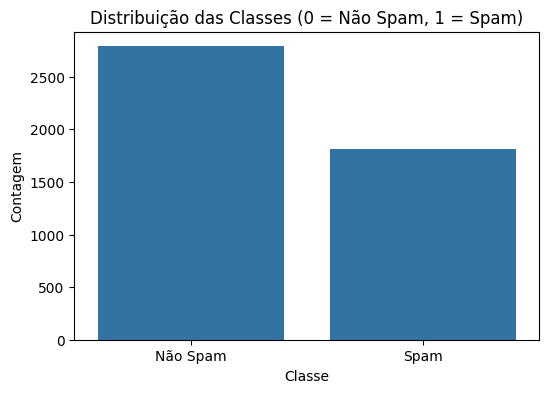



Distribuição percentual das classes:
spam
Não Spam    60.596
Spam        39.404
Name: proportion, dtype: float64


In [60]:
# Checagem de valores nulos
print("Total de valores nulos no DataFrame:", df.isnull().sum().sum())

# Distribuição das classes
plt.figure(figsize=(6, 4))
sns.countplot(x='spam', data=df)
plt.title('Distribuição das Classes (0 = Não Spam, 1 = Spam)')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.xticks([0, 1], ['Não Spam', 'Spam'])
plt.show()

print("\n\nDistribuição percentual das classes:")
percentuais = df['spam'].value_counts(normalize=True).rename({0: 'Não Spam', 1: 'Spam'}) * 100
print(percentuais.round(3))

##### Estatísticas descritivas por classe

In [61]:
print("Média das principais features por classe:")
print(df.groupby('spam')[['char_frequency_!', 'char_frequency_$', 'word_frequency_free', 'capital_run_length_average']].mean())

Média das principais features por classe:
      char_frequency_!  char_frequency_$  word_frequency_free  \
spam                                                            
0             0.109984          0.011648             0.073587   
1             0.513713          0.174478             0.518362   

      capital_run_length_average  
spam                              
0                       2.377301  
1                       9.519165  


####  Boxplot de uma feature relevante

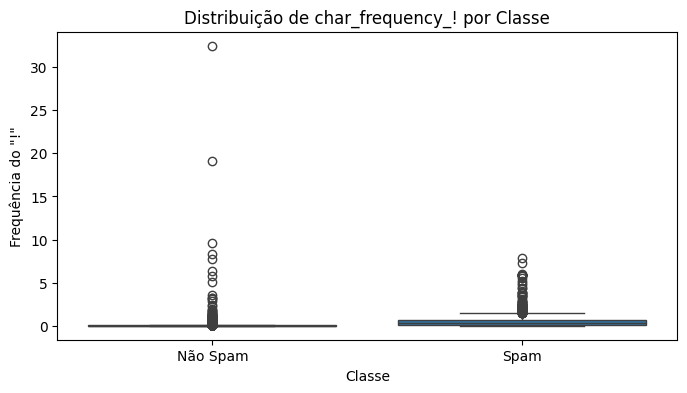

In [62]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='spam', y='char_frequency_!', data=df)
plt.title('Distribuição de char_frequency_! por Classe')
plt.xlabel('Classe')
plt.ylabel('Frequência do "!"')
plt.xticks([0, 1], ['Não Spam', 'Spam'])
plt.show()


##### Correlação das features com a variável alvo

In [63]:
correlations = df.corr()['spam'].abs().sort_values(ascending=False)
print("Features mais correlacionadas com spam:")
print(correlations.head(10))

Features mais correlacionadas com spam:
spam                        1.000000
word_frequency_your         0.383234
word_frequency_000          0.334787
word_frequency_remove       0.332117
char_frequency_$            0.323629
word_frequency_you          0.273651
word_frequency_free         0.263215
word_frequency_business     0.263204
word_frequency_hp           0.256723
capital_run_length_total    0.249164
Name: spam, dtype: float64


#### Heatmap das 10 features mais correlacionadas

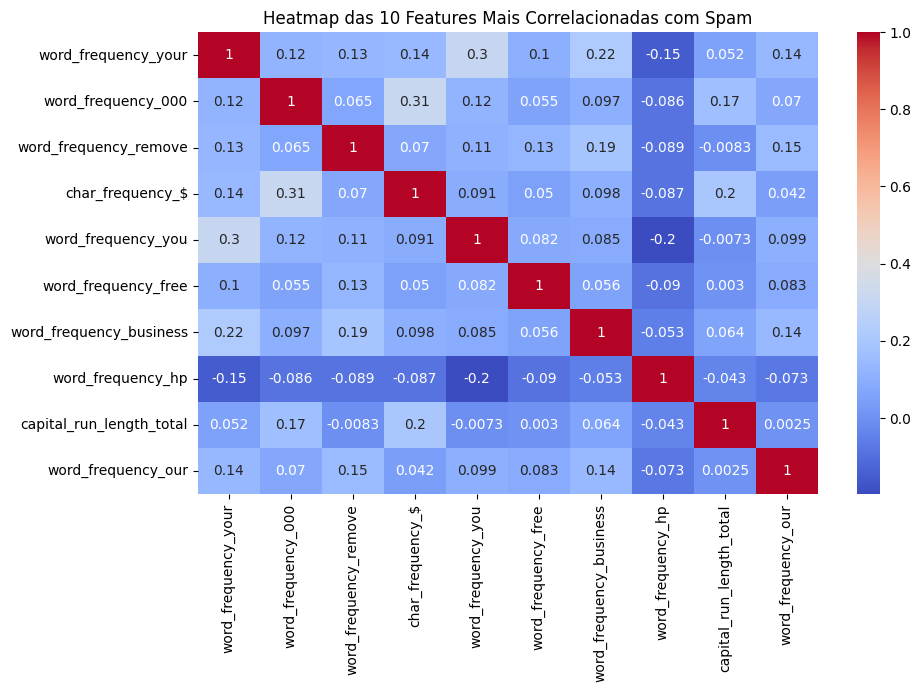

In [64]:
top_corr_features = correlations.index[1:11]  # Ignora a própria 'spam'
plt.figure(figsize=(10, 6))
sns.heatmap(df[top_corr_features].corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap das 10 Features Mais Correlacionadas com Spam')
plt.show()

#### 3. Pré-processamento e Divisão dos Dados

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separando as features -> X e o alvo(target) -> y
X = df.drop('spam', axis=1)
y = df['spam']

# Dividindo os dados em conjuntos de treino e teste (80% treino, 20% teste)
# Usamos stratify=y para manter a mesma proporção de spam/não-spam nos dois conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalonamento dos dados
# O scaler foi criado e ajustado apenas com os dados de treino para evitar vazamento de dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 4. Treinamento e Avaliação dos Modelos

--- Treinando e Avaliando: KNN ---
Tempo de treinamento: 0.00 segundos

Relatório de Classificação:
              precision    recall  f1-score   support

    Não Spam       0.92      0.93      0.92       558
        Spam       0.89      0.88      0.88       363

    accuracy                           0.91       921
   macro avg       0.90      0.90      0.90       921
weighted avg       0.91      0.91      0.91       921



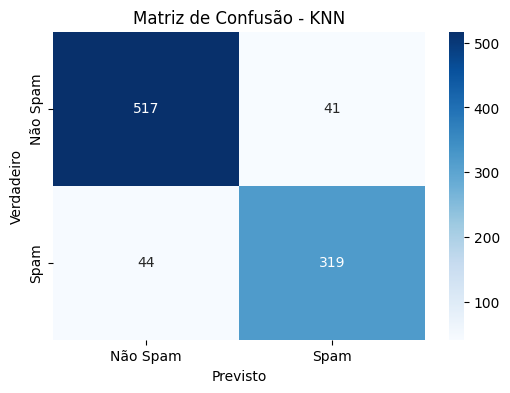

--------------------------------------------------

--- Treinando e Avaliando: SVM ---
Tempo de treinamento: 0.19 segundos

Relatório de Classificação:
              precision    recall  f1-score   support

    Não Spam       0.93      0.96      0.94       558
        Spam       0.93      0.88      0.91       363

    accuracy                           0.93       921
   macro avg       0.93      0.92      0.92       921
weighted avg       0.93      0.93      0.93       921



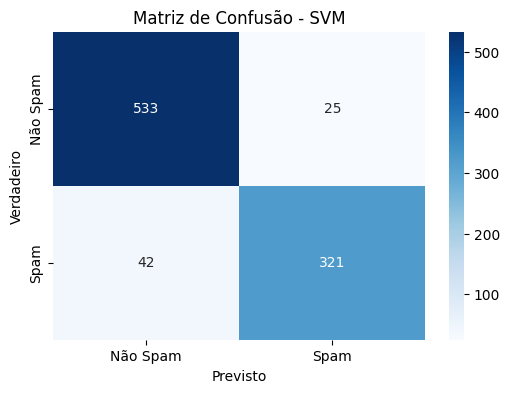

--------------------------------------------------

--- Treinando e Avaliando: Random Forest ---
Tempo de treinamento: 0.53 segundos

Relatório de Classificação:
              precision    recall  f1-score   support

    Não Spam       0.94      0.97      0.95       558
        Spam       0.95      0.91      0.93       363

    accuracy                           0.94       921
   macro avg       0.95      0.94      0.94       921
weighted avg       0.94      0.94      0.94       921



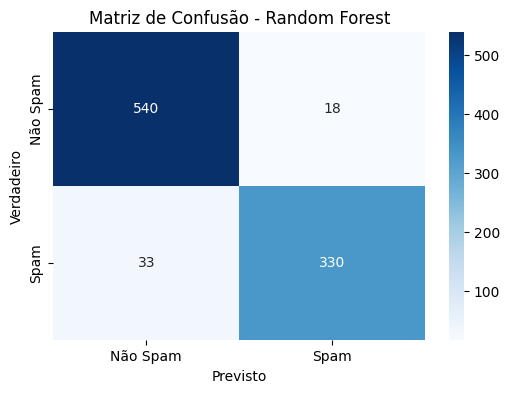

--------------------------------------------------

--- Treinando e Avaliando: Rede Neural (MLP) ---
Tempo de treinamento: 0.62 segundos

Relatório de Classificação:
              precision    recall  f1-score   support

    Não Spam       0.95      0.95      0.95       558
        Spam       0.93      0.92      0.92       363

    accuracy                           0.94       921
   macro avg       0.94      0.94      0.94       921
weighted avg       0.94      0.94      0.94       921



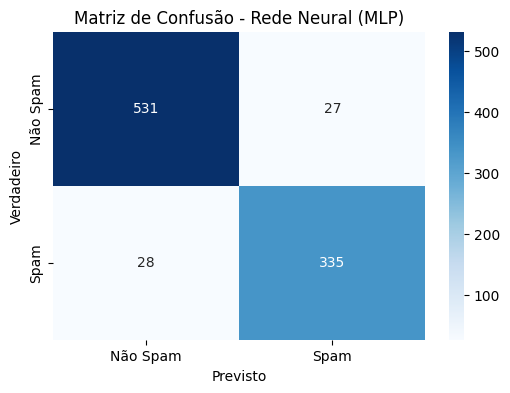

--------------------------------------------------



In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.inspection import permutation_importance
import time

# Dicionário com os modelos a serem treinados
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(random_state=42, kernel='rbf', C=1.0),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None),
    "Rede Neural (MLP)": MLPClassifier(
      random_state=42,
      hidden_layer_sizes=(100, 50, 25),
      activation='relu',
      solver='adam',
      learning_rate_init=0.001,
      max_iter=2000,
      alpha=0.0001,
      early_stopping=True,
      validation_fraction=0.1,
      n_iter_no_change=10
    )
}

# Armazenar resultados detalhados
results = {}
detailed_results = {}
training_times = {}

# Loop para treinar e avaliar cada modelo
for name, model in models.items():
    print(f"--- Treinando e Avaliando: {name} ---")

    # Medir tempo de treinamento
    start_time = time.time()

    # Treinar o modelo com os dados escalonados
    model.fit(X_train_scaled, y_train)

    end_time = time.time()
    training_time = end_time - start_time
    training_times[name] = training_time

    print(f"Tempo de treinamento: {training_time:.2f} segundos")

    # Fazer previsões no conjunto de teste
    y_pred = model.predict(X_test_scaled)

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])

    results[name] = accuracy
    detailed_results[name] = {
        'accuracy': accuracy,
        'precision_nao_spam': precision[0],
        'recall_nao_spam': recall[0],
        'f1_nao_spam': f1[0],
        'precision_spam': precision[1],
        'recall_spam': recall[1],
        'f1_spam': f1[1],
        'training_time': training_time
    }

    # Exibir o relatório de classificação
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=['Não Spam', 'Spam']))

    # Exibir a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Não Spam', 'Spam'],
                yticklabels=['Não Spam', 'Spam'])
    plt.title(f'Matriz de Confusão - {name}')
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.show()
    print("-" * 50 + "\n")


#### Comparação visual das acurácias

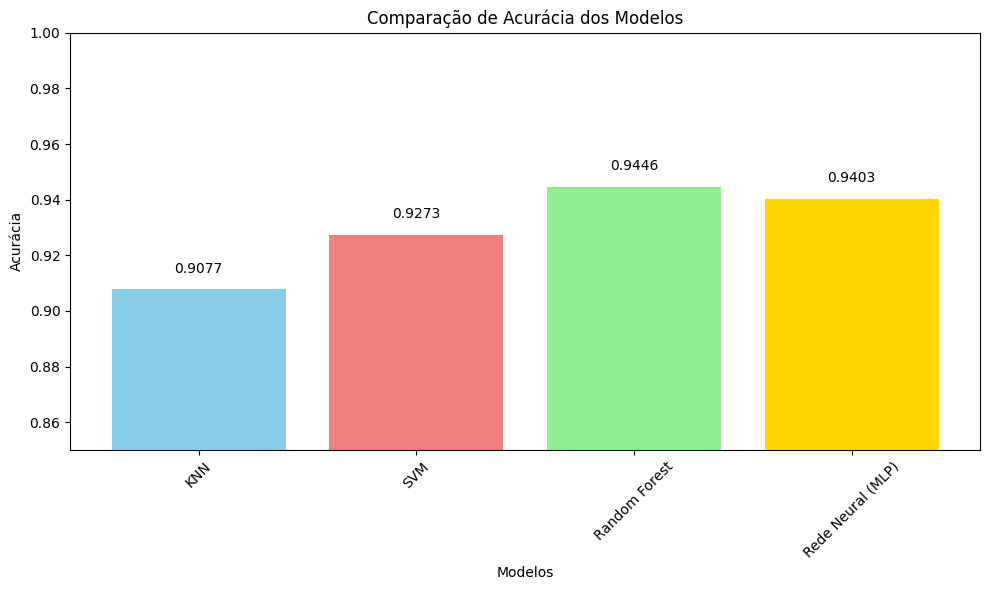

=== RESUMO DOS RESULTADOS ===
                   accuracy  precision_nao_spam  recall_nao_spam  f1_nao_spam  \
KNN                  0.9077              0.9216           0.9265       0.9240   
SVM                  0.9273              0.9270           0.9552       0.9409   
Random Forest        0.9446              0.9424           0.9677       0.9549   
Rede Neural (MLP)    0.9403              0.9499           0.9516       0.9508   

                   precision_spam  recall_spam  f1_spam  training_time  
KNN                        0.8861       0.8788   0.8824         0.0014  
SVM                        0.9277       0.8843   0.9055         0.1918  
Random Forest              0.9483       0.9091   0.9283         0.5337  
Rede Neural (MLP)          0.9254       0.9229   0.9241         0.6204  


In [67]:
plt.figure(figsize=(10, 6))
model_names = list(results.keys())
accuracies = list(results.values())

bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title('Comparação de Acurácia dos Modelos')
plt.xlabel('Modelos')
plt.ylabel('Acurácia')
plt.ylim(0.85, 1.0)  # Ajustar conforme seus resultados

# Adicionar valores nas barras
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{acc:.4f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Tabela resumo dos resultados
print("=== RESUMO DOS RESULTADOS ===")
results_df = pd.DataFrame(detailed_results).T
results_df = results_df.round(4)
print(results_df)

#### Curva de aprendizado da MLP

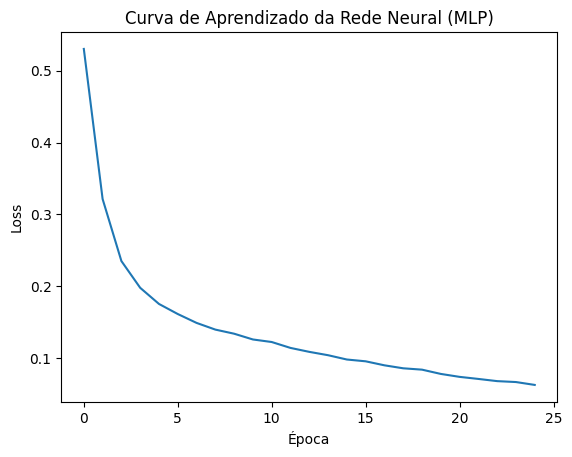

In [68]:
mlp = models["Rede Neural (MLP)"]
plt.plot(mlp.loss_curve_)
plt.title('Curva de Aprendizado da Rede Neural (MLP)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.show()

#### 5. Comparação dos Resultados

In [69]:
# DataFrame completo com todas as métricas
results_df = pd.DataFrame(detailed_results).T.reset_index().rename(columns={'index': 'Modelo'})
results_df = results_df[['Modelo', 'accuracy', 'precision_spam', 'recall_spam', 'f1_spam', 'training_time']]
results_df.columns = ['Modelo', 'Acurácia', 'Precisão (Spam)', 'Recall (Spam)', 'F1 (Spam)', 'Tempo de Treinamento (s)']
results_df = results_df.sort_values(by='Acurácia', ascending=False)

print("Tabela Comparativa de Desempenho:")
print(results_df)

Tabela Comparativa de Desempenho:
              Modelo  Acurácia  Precisão (Spam)  Recall (Spam)  F1 (Spam)  \
2      Random Forest  0.944625         0.948276       0.909091   0.928270   
3  Rede Neural (MLP)  0.940282         0.925414       0.922865   0.924138   
1                SVM  0.927253         0.927746       0.884298   0.905501   
0                KNN  0.907709         0.886111       0.878788   0.882434   

   Tempo de Treinamento (s)  
2                  0.533724  
3                  0.620378  
1                  0.191819  
0                  0.001392  


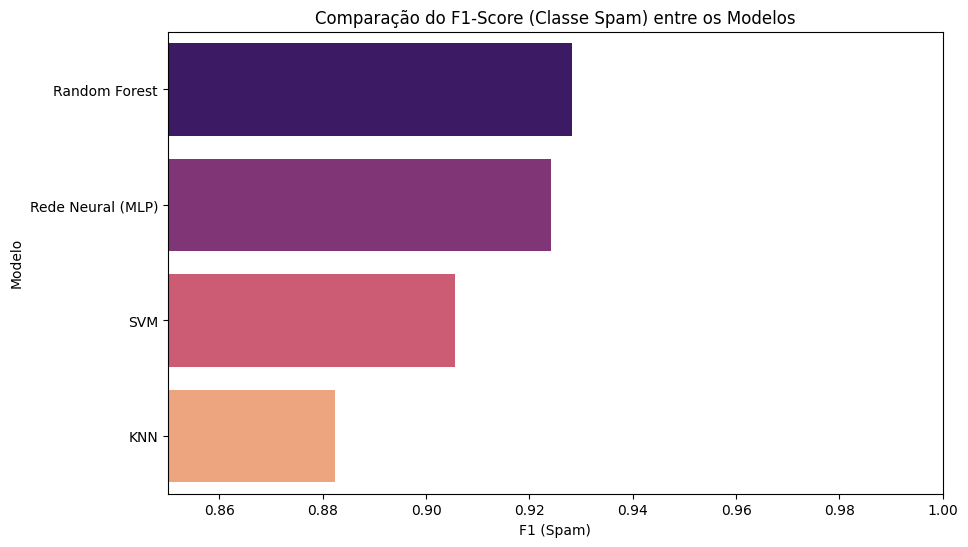

In [70]:
plt.figure(figsize=(10, 6))
sns.barplot(x='F1 (Spam)', y='Modelo', data=results_df, hue='Modelo', palette='magma', legend=False)
plt.title('Comparação do F1-Score (Classe Spam) entre os Modelos')
plt.xlim(0.85, 1.0)
plt.show()

#### Gráfico de Radar (Comparação Multimétrica dos Modelos)

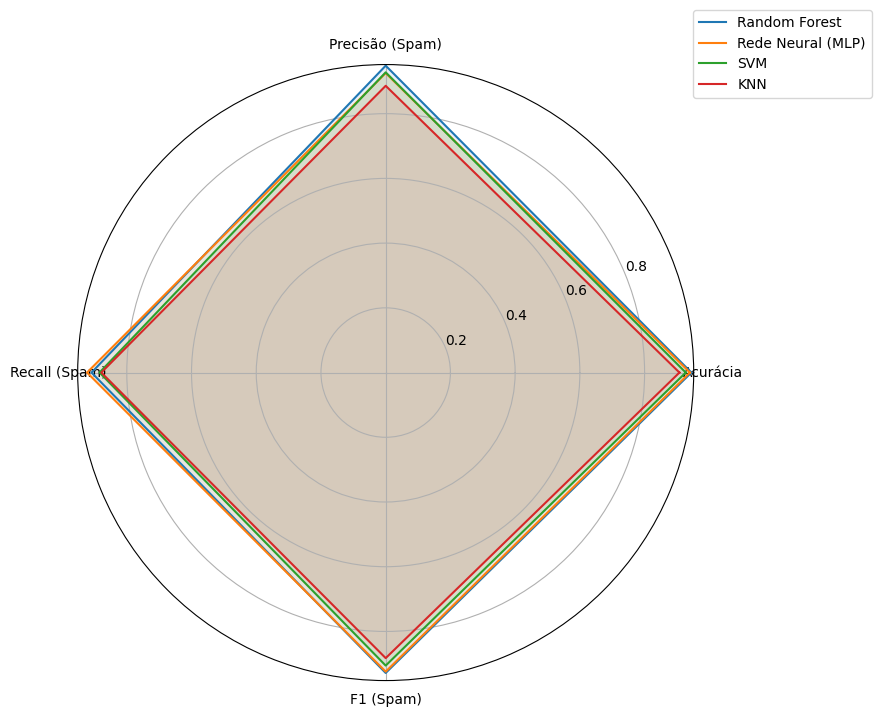

In [71]:
import numpy as np

metrics = ['Acurácia', 'Precisão (Spam)', 'Recall (Spam)', 'F1 (Spam)']
labels = results_df['Modelo']
num_vars = len(metrics)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, row in results_df.iterrows():
    values = row[metrics].tolist()
    values += values[:1]
    ax.plot(angles, values, label=row['Modelo'])
    ax.fill(angles, values, alpha=0.1)

ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
# plt.title('Comparação Multimétrica dos Modelos')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

#### Tabela Comparativa das Top Features

Top 15 Features mais importantes para detectar Spam:
                       feature  importance
51            char_frequency_!    0.113785
52            char_frequency_$    0.104051
6        word_frequency_remove    0.081335
15         word_frequency_free    0.067762
54  capital_run_length_average    0.062623
55  capital_run_length_longest    0.055419
56    capital_run_length_total    0.053460
20         word_frequency_your    0.048920
24           word_frequency_hp    0.044283
18          word_frequency_you    0.033458
23        word_frequency_money    0.031630
4           word_frequency_our    0.026138
22          word_frequency_000    0.025859
26       word_frequency_george    0.021660
45          word_frequency_edu    0.017418


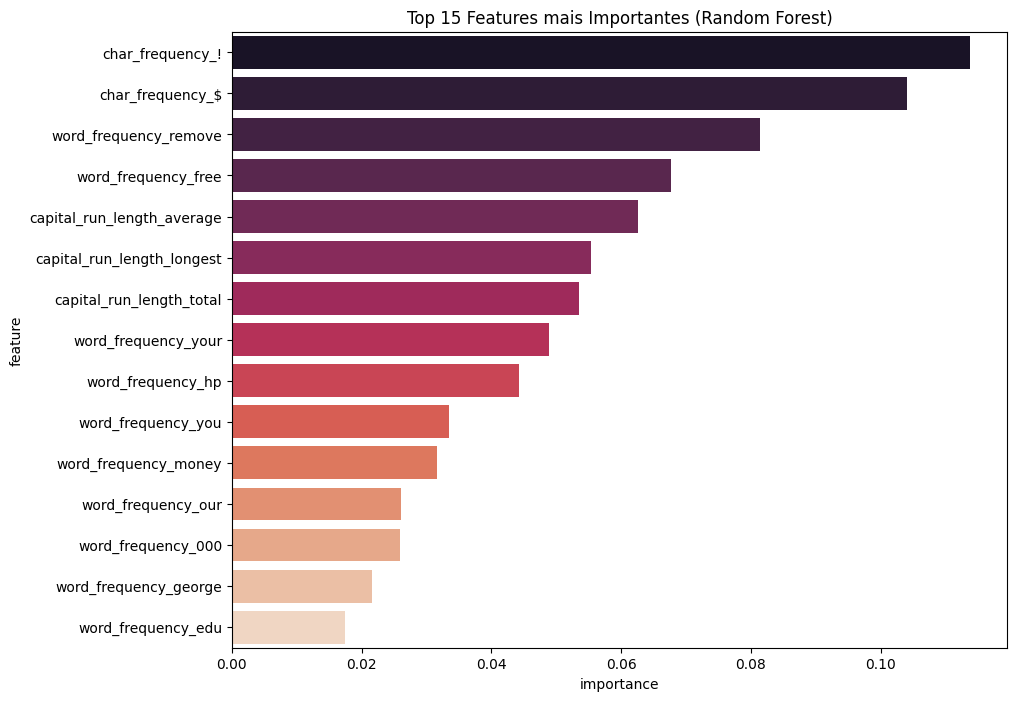

In [72]:
# Importância das Features (com Random Forest)
rf_model = models['Random Forest']

# Criar um DataFrame com as features e sua importância
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Exibe as 15 features mais importantes
print("Top 15 Features mais importantes para detectar Spam:")
print(feature_importances.head(15))

# Plota as features mais importantes
plt.figure(figsize=(10, 8))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importances.head(15),
    hue='feature',
    palette='rocket',
    legend=False
)
plt.title('Top 15 Features mais Importantes (Random Forest)')
plt.show()

#### Importância das Features para a MLP (usando Permutation Importance)

--- Calculando a Importância das Features para a Rede Neural (MLP) ---

Top 15 Features mais importantes para a MLP:
                     feature  importance_mean
24         word_frequency_hp         0.028230
6      word_frequency_remove         0.019544
51          char_frequency_!         0.017481
52          char_frequency_$         0.017264
4         word_frequency_our         0.016395
26     word_frequency_george         0.016069
45        word_frequency_edu         0.014007
15       word_frequency_free         0.013898
25        word_frequency_hpl         0.009446
11       word_frequency_will         0.009012
22        word_frequency_000         0.008795
34         word_frequency_85         0.006080
56  capital_run_length_total         0.005972
21       word_frequency_font         0.005537
40         word_frequency_cs         0.005103


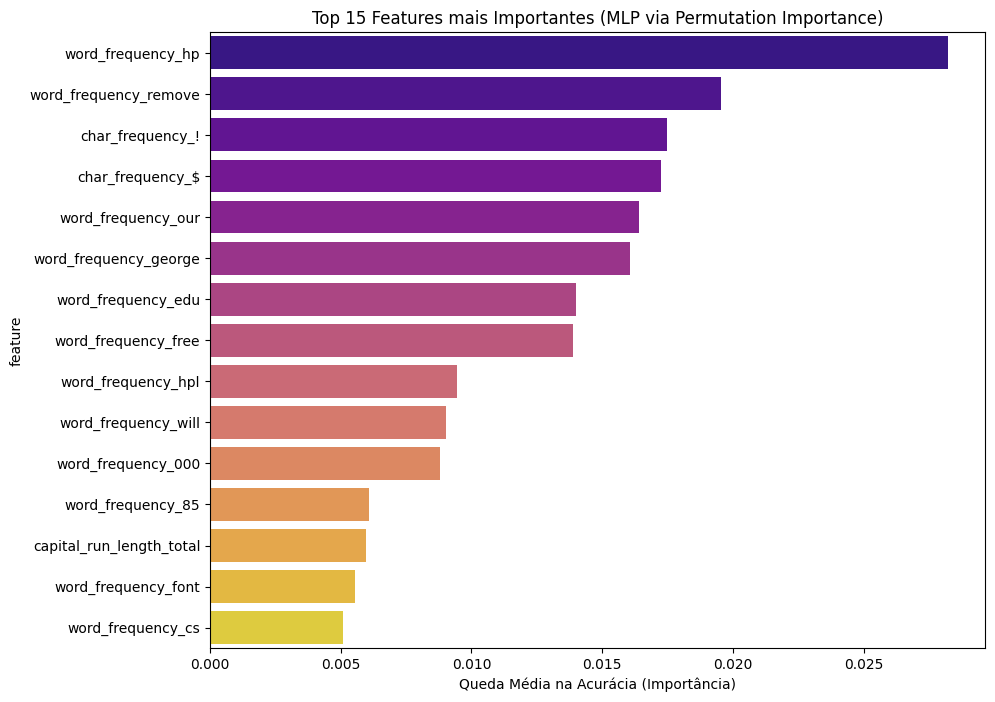

In [73]:
from sklearn.inspection import permutation_importance

print("--- Calculando a Importância das Features para a Rede Neural (MLP) ---")

# Pegar o modelo MLP já treinado
mlp_model = models['Rede Neural (MLP)']

# Calcular a importância por permutação nos dados de teste
# Usamos os dados de teste para avaliar o quão importante cada feature é para a generalização do modelo
result = permutation_importance(
    mlp_model, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Organizar os resultados em um DataFrame
mlp_importances = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': result.importances_mean
}).sort_values('importance_mean', ascending=False)

# Exibir as 15 features mais importantes
print("\nTop 15 Features mais importantes para a MLP:")
print(mlp_importances.head(15))

# Plotar as features mais importantes
plt.figure(figsize=(10, 8))
sns.barplot(
    x='importance_mean',
    y='feature',
    data=mlp_importances.head(15),
    palette='plasma',
    hue='feature',
    legend=False
)
plt.title('Top 15 Features mais Importantes (MLP via Permutation Importance)')
plt.xlabel('Queda Média na Acurácia (Importância)')
plt.show()